# Three-Stage Grid Search: Reproduce Plots/Tables


This notebook reproduces the **Three-Stage Grid Search** plot(s) and table(s) used in the paper.

**Expected repo layout (relative paths):**
- `Structured Outputs/3-Stage/3_stage.csv` (or `.xlsx`)
- This notebook should live in `Plotting Code/`

Outputs are saved into:
- `Structured Outputs/3-Stage/Images/`


In [6]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
SAVE_FIGS = True
FIG_DPI = 200

def find_project_root(start: Path | None = None) -> Path:
    """Walk upward until we find 'Structured Outputs'."""
    here = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (here / 'Structured Outputs').exists():
            return here
        here = here.parent
    raise FileNotFoundError(
        "Could not find project root containing 'Structured Outputs'.\n"
        "Run this notebook from within the repo (ideally from 'Plotting Code/')."
    )

PROJECT_ROOT = find_project_root()
STRUCTURED_DIR = PROJECT_ROOT / 'Structured Outputs'
DATA_DIR = STRUCTURED_DIR / '3-Stage'
OUT_DIR = DATA_DIR / 'Images'
OUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / '3_stage.csv'
XLSX_PATH = DATA_DIR / '3_stage.xlsx'

def save_fig(fig: plt.Figure, stem: str):
    if not SAVE_FIGS:
        return
    png = OUT_DIR / f"{stem}.png"
    pdf = OUT_DIR / f"{stem}.pdf"
    fig.savefig(png, dpi=FIG_DPI, bbox_inches='tight')
    fig.savefig(pdf, bbox_inches='tight')
    print(f"Saved: {png}\nSaved: {pdf}")

In [7]:
# --- Load data ---
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
elif XLSX_PATH.exists():
    # Prefer a sheet called 'parsed_epochs' if it exists, else take the first sheet.
    try:
        df = pd.read_excel(XLSX_PATH, sheet_name='parsed_epochs')
    except Exception:
        df = pd.read_excel(XLSX_PATH, sheet_name=0)
else:
    raise FileNotFoundError(f"Missing both {CSV_PATH} and {XLSX_PATH}")

df.head(), df.shape

(      seed  phase phase_name  phase_total_runs  phase_epochs_per_run  run_idx  \
 0  [38042]      1   baseline                27                    20        1   
 1  [38042]      1   baseline                27                    20        1   
 2  [38042]      1   baseline                27                    20        1   
 3  [38042]      1   baseline                27                    20        1   
 4  [38042]      1   baseline                27                    20        1   
 
    run_total      lr    wd   bs  drop_path_rate  epoch  epoch_total    loss  \
 0         27  0.0001  0.02  256             0.0      1           20  2.0423   
 1         27  0.0001  0.02  256             0.0      2           20  1.8476   
 2         27  0.0001  0.02  256             0.0      3           20  1.7396   
 3         27  0.0001  0.02  256             0.0      4           20  1.6291   
 4         27  0.0001  0.02  256             0.0      5           20  1.4833   
 
    train_acc_pct  test_

In [8]:
# ---- Robust seed parsing ----
# Some exports store the seed as a string like "[38042]" instead of a bare integer.
# We normalize it to an int so downstream code can safely do numeric operations / sorting.

import re
import pandas as pd

def _normalize_seed(x):
    # Already numeric
    if isinstance(x, (int,)):
        return int(x)
    if isinstance(x, float) and pd.notna(x):
        return int(x)
    # Lists / tuples like [38042]
    if isinstance(x, (list, tuple)) and len(x) > 0:
        try:
            return int(x[0])
        except Exception:
            pass
    # Strings like "[38042]" or "seed=38042"
    if isinstance(x, str):
        m = re.search(r"(\d+)", x)
        if m:
            return int(m.group(1))
    return None

if "seed" in df.columns:
    df["seed"] = df["seed"].apply(_normalize_seed)
    df = df[df["seed"].notna()].copy()


In [9]:
# --- Sanity check required columns ---
required = {
    'seed', 'phase', 'run_idx', 'epoch', 'epoch_total',
    'lr', 'wd', 'bs', 'drop_path_rate',
    'loss', 'train_acc_pct', 'test_acc_pct'
}
missing = sorted(list(required - set(df.columns)))
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Make sure phases are sorted and integer
df['phase'] = df['phase'].astype(int)
df['epoch'] = df['epoch'].astype(int)
df = df.sort_values(['seed', 'phase', 'run_idx', 'epoch']).reset_index(drop=True)

df[['seed','phase','run_idx','epoch','loss','test_acc_pct']].head()

,seed,phase,run_idx,epoch,loss,test_acc_pct
0,38042,1,1,1,2.0423,28.48
1,38042,1,1,2,1.8476,34.58
2,38042,1,1,3,1.7396,36.33
3,38042,1,1,4,1.6291,43.45
4,38042,1,1,5,1.4833,47.58


In [10]:
# === Table 3: Best configuration per seed, separately for each phase ===
# We define 'best run' as the run_idx with the highest FINAL validation accuracy in that phase.

def final_rows_in_phase(d: pd.DataFrame) -> pd.DataFrame:
    return d[d['epoch'] == d['epoch_total'].max()].copy()

df_final = df.groupby(['seed','phase','run_idx'], as_index=False).apply(lambda g: g[g['epoch']==g['epoch_total'].max()]).reset_index(drop=True)

table3 = (
    df_final.sort_values(['phase','seed','test_acc_pct'], ascending=[True, True, False])
    .groupby(['phase','seed'], as_index=False)
    .head(1)
    .rename(columns={
        'test_acc_pct': 'Acc (%)',
        'lr': 'LR',
        'wd': 'WD',
        'bs': 'BS',
        'drop_path_rate': 'DPR'
    })
    [['phase','seed','Acc (%)','LR','WD','BS','DPR']]
    .sort_values(['phase','seed'])
)

table3_out = OUT_DIR / 'table3_best_per_seed_each_phase.csv'
table3.to_csv(table3_out, index=False)
print(f"Saved: {table3_out}")
table3.head(10)

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/3-Stage/Images/table3_best_per_seed_each_phase.csv


/var/folders/s9/1y41t7n13cz08lgqk5mtc_1m0000gn/T/ipykernel_24771/1628664279.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_final = df.groupby(['seed','phase','run_idx'], as_index=False).apply(lambda g: g[g['epoch']==g['epoch_total'].max()]).reset_index(drop=True)


,phase,seed,Acc (%),LR,WD,BS,DPR
18,1,38042,78.57,0.00100,0.02,256,0.0
28,2,38042,79.69,0.00001,0.02,256,0.1
77,3,38042,80.21,0.00001,0.07,256,0.2


Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/3-Stage/Images/fig3_three_stage_across_phases.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/3-Stage/Images/fig3_three_stage_across_phases.pdf


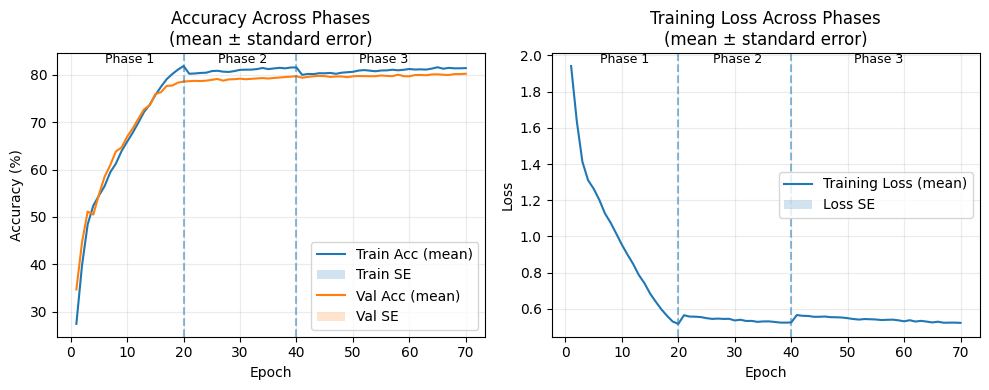

In [11]:
# === Figure 3: Accuracy + loss across phases (mean ± standard error across seeds) ===
# For each (seed, phase), we take the *best* run in that phase (by final val accuracy),
# then concatenate the 3 phase-curves into one global timeline. Finally, we compute
# mean ± standard error across seeds.

# Identify best run_idx per (seed, phase)
best_runs = (
    df_final.sort_values(['seed','phase','test_acc_pct'], ascending=[True, True, False])
    .groupby(['seed','phase'], as_index=False)
    .head(1)[['seed','phase','run_idx']]
)

# Determine per-phase lengths (epoch_total)
phase_lengths = (
    df.groupby('phase', as_index=False)['epoch_total']
    .max()
    .sort_values('phase')
)
phase_to_len = dict(zip(phase_lengths['phase'], phase_lengths['epoch_total']))
phases_sorted = sorted(phase_to_len.keys())
offsets = {}
cum = 0
for ph in phases_sorted:
    offsets[ph] = cum
    cum += int(phase_to_len[ph])

def build_seed_curve(seed: int) -> pd.DataFrame:
    rows = []
    for ph in phases_sorted:
        run_row = best_runs[(best_runs['seed']==seed) & (best_runs['phase']==ph)]
        if len(run_row)==0:
            continue
        run_idx = int(run_row['run_idx'].iloc[0])
        g = df[(df['seed']==seed) & (df['phase']==ph) & (df['run_idx']==run_idx)].copy()
        g['global_epoch'] = g['epoch'] + offsets[ph]
        rows.append(g)
    if not rows:
        return pd.DataFrame()
    out = pd.concat(rows, ignore_index=True).sort_values('global_epoch')
    return out

seed_curves = []
for s in sorted(df['seed'].dropna().unique()):
    sc = build_seed_curve(int(s))
    if len(sc):
        seed_curves.append(sc)

if not seed_curves:
    raise ValueError('No seed curves could be built (check phases/run_idx parsing).')

df_curve = pd.concat(seed_curves, ignore_index=True)

# Aggregate across seeds at each global_epoch
n_seeds = df_curve['seed'].nunique()
agg = (
    df_curve.groupby('global_epoch', as_index=False)
    .agg(
        train_acc_mean=('train_acc_pct','mean'),
        train_acc_std=('train_acc_pct','std'),
        val_acc_mean=('test_acc_pct','mean'),
        val_acc_std=('test_acc_pct','std'),
        loss_mean=('loss','mean'),
        loss_std=('loss','std'),
    )
)
agg['train_acc_se'] = agg['train_acc_std'].fillna(0) / np.sqrt(n_seeds)
agg['val_acc_se'] = agg['val_acc_std'].fillna(0) / np.sqrt(n_seeds)
agg['loss_se'] = agg['loss_std'].fillna(0) / np.sqrt(n_seeds)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: accuracy
axes[0].plot(agg['global_epoch'], agg['train_acc_mean'], label='Train Acc (mean)')
axes[0].fill_between(
    agg['global_epoch'],
    agg['train_acc_mean'] - agg['train_acc_se'],
    agg['train_acc_mean'] + agg['train_acc_se'],
    alpha=0.2,
    label='Train SE'
)
axes[0].plot(agg['global_epoch'], agg['val_acc_mean'], label='Val Acc (mean)')
axes[0].fill_between(
    agg['global_epoch'],
    agg['val_acc_mean'] - agg['val_acc_se'],
    agg['val_acc_mean'] + agg['val_acc_se'],
    alpha=0.2,
    label='Val SE'
)
axes[0].set_title('Accuracy Across Phases\n(mean ± standard error)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].grid(True, alpha=0.25)
axes[0].legend()

# Right: training loss
axes[1].plot(agg['global_epoch'], agg['loss_mean'], label='Training Loss (mean)')
axes[1].fill_between(
    agg['global_epoch'],
    agg['loss_mean'] - agg['loss_se'],
    agg['loss_mean'] + agg['loss_se'],
    alpha=0.2,
    label='Loss SE'
)
axes[1].set_title('Training Loss Across Phases\n(mean ± standard error)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.25)
axes[1].legend()

# Add phase boundaries + labels
for ph in phases_sorted[:-1]:
    boundary = offsets[ph] + phase_to_len[ph]
    for ax in axes:
        ax.axvline(boundary, linestyle='--', alpha=0.5)

# Place phase labels near the top of each plot
for ph in phases_sorted:
    start = offsets[ph] + 1
    end = offsets[ph] + phase_to_len[ph]
    mid = 0.5*(start+end)
    axes[0].text(mid, axes[0].get_ylim()[1], f'Phase {ph}', ha='center', va='top', fontsize=9)
    axes[1].text(mid, axes[1].get_ylim()[1], f'Phase {ph}', ha='center', va='top', fontsize=9)

plt.tight_layout()
save_fig(fig, 'fig3_three_stage_across_phases')
plt.show()